In [ ]:
!pip install --ignore-installed libsvm

## What is Image Quality Assessment (IQA)?

Image Quality Assessment (IQA) algorithms take an arbitrary image as input and output a quality score as output. There are three types of IQAs:

   **Full-Reference IQA :** Here you have a ‘clean’ reference (non-distorted) image to measure the quality of your distorted image. This measure may be used in assessing the quality of an image compression algorithm where we have access to both the original image and its compressed version.  
    
   **Reduced-Reference IQA:** Here you don’t have a reference image, but an image having some selective information about it (e.g. watermarked image) to compare and measure the quality of distorted image.  
    
   **Objective Blind or No-Reference IQA:** The only input the algorithm gets is the image whose quality you want to measure. This is thus called, No-Reference or Objective-Blind.

### No-Reference IQA

In this post, we will discuss one of the No-Reference IQA Metrics, called Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE). Before we go deeper into the theory, let’s first understand two basic terms:

**Distorted Image:** As the name suggests, a distorted image is a version of the original image that is distorted by blur, noise, watermarking, color transformations, geometric transformations and so on and so forth. 
  
**Natural Image:** An image directly captured by a camera with no post processing is a natural image in our context.

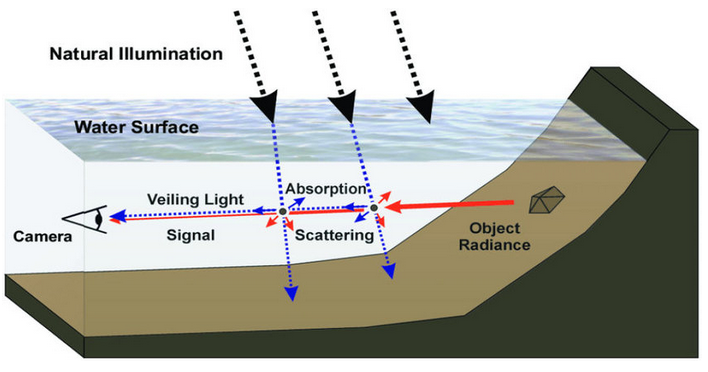

To teach an algorithm about good and bad quality, we need to show the algorithm examples of many images and their quality score.

Who assigns the quality score for these training images? Humans, of course. But we cannot rely on the opinion of just one human. So we need opinions of several humans and assign the image a mean score between 0 (best) and 100 (worst). This score is called the **Mean Quality Score**.  
  
Fortunately, this dataset called **TID2008** has been made available for research purposes.

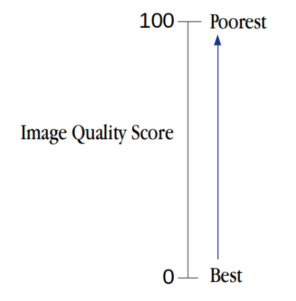

## Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE)

Steps to Calculate Image Quality Score using BRISQUE Model

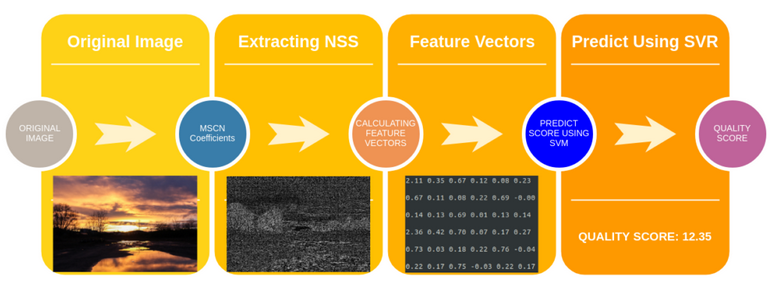

### Step 1: Extract Natural Scene Statistics (NSS)  
  
The distribution of pixel intensities of natural images differs from that of distorted images. This difference in distributions is much more pronounced when we normalize pixel intensities and calculate the distribution over these normalized intensities. In particular, after normalization pixel intensities of natural images follow a Gaussian Distribution (Bell Curve) while pixel intensities of unnatural or distorted images do not. The deviation of the distribution from an ideal bell curve is therefore a measure of the amount of distortion in the image.

#### Mean Substracted Contrast Normalization (MSCN)

There are a few different ways to normalize an image. One such normalization is called **Mean Substracted Contrast Normalization (MSCN).** The figure below shows how to calculate MSCN coefficients.

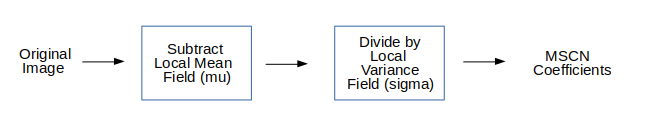

This can be visualized as:

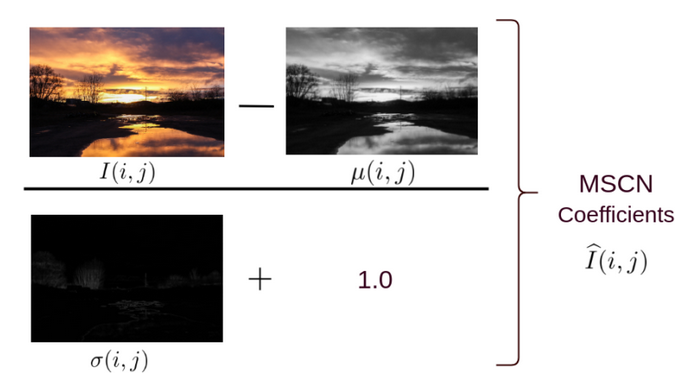

### Natural Scene Statistics Extraction

All natural images share some common statistical behaviors regularities related to the real world. One of the best examples of NSS is MSCN coefficients where its histogram is approximately Gaussian like for a natural image

To calculate the MSCN Coefficients, the image intensity $ I(i,j)$ at pixel $(i, j)$ is transformed to the luminance $\widehat{I}(i, j)$  
$\widehat{I}(i, j) = \dfrac {I(i,j) - \mu (i,j)}{\sigma (i,j) + d}$

Where $i \in (1,2,...,M)$ and $J \in (1,2,...,N)$ are spatial indices of a natural images's pixels with size $M \times N$ and $d$ is small value to prevent division by zero.  
Functions $\mu$ and $\sigma$ are local mean field and local variance field respectively and can be calcultaed by

**W** is the Gaussian Blur  function  
$\mu = W * I$  
$\sigma =  \sqrt{(W*(I-\mu)^2)}$

In [1]:
import cv2
import numpy as np
import math as m
import sys
# for gamma function, called 
from scipy.special import gamma as tgamma
import os

In [2]:
# load libsvm packages
from libsvm import svm 
from libsvm import svmutil
from svm import *
from svmutil import *

### Pairwise products for neighborhood releationships

MSCN provides a good normalization for pixel intensities. However, the difference in natural vs. distorted images is not limited to pixel intensity distributions, but also the relationship between a pixel and its neighbors.  
  
To capture neighborhood relationshiops the authors used pair-wise products of MSCN image with a shifted version of the MSCN image. Four orientations are used to find the pairwise product for the MSCN coefficients, namely: Horizontal (H), Vertical (V), Left-Diagonal (D1), Right-Diagonal (D2).  

$H(i,j) = \hat I(i,j) \hat I(i,j+1) $  
$V(i,j) = \hat I(i,j) \hat I(i+1,j) $  
$D1(i,j) = \hat I(i,j) \hat I(i+1, j+1)$  
$D2(i,j) = \hat I(i,j) \hat I(i+1, j-1)$  


In [3]:
# AGGD fit model, takes input as the MSCN Image / Pair-wise Product
def AGGDfit(structdis):
    # variables to count positive pixels / negative pixels and their squared sum
    poscount = 0  # count positive pixels
    negcount = 0  # count negative pixels
    possqsum = 0  # sum of negative pixels
    negsqsum = 0  # sum of negative pixels
    abssum   = 0  # absolute sum 

    poscount = len(structdis[structdis > 0]) # number of positive pixels
    negcount = len(structdis[structdis < 0]) # number of negative pixels
    
    # calculate squared sum of positive pixels and negative pixels
    possqsum = np.sum(np.power(structdis[structdis > 0], 2))
    negsqsum = np.sum(np.power(structdis[structdis < 0], 2))
    
    # absolute squared sum
    abssum = np.sum(structdis[structdis > 0]) + np.sum(-1 * structdis[structdis < 0])

    # calculate left sigma variance and right sigma variance
    lsigma_best = np.sqrt((negsqsum/negcount))
    rsigma_best = np.sqrt((possqsum/poscount))

    gammahat = lsigma_best/rsigma_best
    
    # total number of pixels - totalcount
    totalcount = structdis.shape[1] * structdis.shape[0]

    rhat = m.pow(abssum/totalcount, 2)/((negsqsum + possqsum)/totalcount)
    rhatnorm = rhat * (m.pow(gammahat, 3) + 1) * (gammahat + 1)/(m.pow(m.pow(gammahat, 2) + 1, 2))
    
    prevgamma = 0
    prevdiff  = 1e10
    sampling  = 0.001
    gam = 0.2

    # vectorized function call for best fitting parameters
    vectfunc = np.vectorize(func, otypes = [np.float32], cache = False)
    
    # calculate best fit params
    gamma_best = vectfunc(gam, prevgamma, prevdiff, sampling, rhatnorm)

    return [lsigma_best, rsigma_best, gamma_best] 

In [4]:
def func(gam, prevgamma, prevdiff, sampling, rhatnorm):
    while(gam < 10):
        r_gam = tgamma(2/gam) * tgamma(2/gam) / (tgamma(1/gam) * tgamma(3/gam))
        diff = abs(r_gam - rhatnorm)
        if(diff > prevdiff): break
        prevdiff = diff
        prevgamma = gam
        gam += sampling
    gamma_best = prevgamma
    return gamma_best

### Step 2 : Calculate Feature Vectors  

Until now, we have derived 5 images from the original image — 1 MSCN image and 4 pairwise product images to capture neighbor relationships (Horizontal, Vertical, Left Diagonal, Right Diagonal).  
  
Next, we will use these 5 images to calculate a feature vector of size 36×1 ( i.e. an array of 18 numbers). Note the original input image could be of any dimension (width/height), but the feature vector is always of size 36×1.  
  
The first two elements of the 36×1 feature vector is calculated by fitting the MSCN image to a Generalized Gaussian Distribution (GGD). A GGD has two parameters — one for shape and one for variance.  
  
Next, an Asymmetric Generalized Gaussian Distribution (AGGD) is fit to each of the four pairwise product images. AGGD is an asymmetric form of Generalized Gaussian Fitting (GGD). It has four parameters — shape, mean, left variance and right variance. Since there are 4 pairwise product images, we end up with 16 values.  
  
Therefore, we end up with 18 elements of the feature vector. The image is downsized to half its original size and the same process is repeated to obtain 18 new numbers bringing the total to 36 numbers.  

This is summarized in the table below.  
  

| Feature Range	| Feature Description | Procedure  |
|---    |:-:    |:-:    |
| 1 - 2	| Shape and Variance.	GGD fit to MSCN coefficients.  | GGD fit to MSCN coefficients.|
| 3 - 6	| Shape, Mean, Left Variance, Right Variance	AGGD fit to Horizontal Pairwise Products | AGGD fit to Horizontal Pairwise Products| 
| 7 - 10|	Shape, Mean, Left Variance, Right Variance	AGGD fit to Vertical Pairwise Products | AGGD fit to Vertical Pairwise Products | 
| 11 - 14|	Shape, Mean, Left Variance, Right Variance	AGGD fit to Diagonal (left) Pairwise Products | AGGD fit to Diagonal (left) Pairwise Products | 
|15 - 18|	Shape, Mean, Left Variance, Right Variance	AGGD fit to Diagonal (Right) Pairwise Products | AGGD fit to Diagonal (Right) Pairwise Products| 

In [5]:
def compute_features(img):
    scalenum = 2
    feat = []
    # make a copy of the image 
    im_original = img.copy()

    # scale the images twice 
    for itr_scale in range(scalenum):
        im = im_original.copy()
        # normalize the image
        im = im / 255.0

        # calculating MSCN coefficients
        mu = cv2.GaussianBlur(im, (7, 7), 1.166)
        mu_sq = mu * mu
        sigma = cv2.GaussianBlur(im*im, (7, 7), 1.166)
        sigma = np.absolute(sigma - mu_sq)**0.5
        
        # structdis is the MSCN image
        structdis = im - mu
        structdis /= (sigma + 1.0/255)
        
        # calculate best fitted parameters from MSCN image
        best_fit_params = AGGDfit(structdis)
        # unwrap the best fit parameters 
        lsigma_best = best_fit_params[0]
        rsigma_best = best_fit_params[1]
        gamma_best  = best_fit_params[2]
        
        # append the best fit parameters for MSCN image
        feat.append(gamma_best)
        feat.append((lsigma_best*lsigma_best + rsigma_best*rsigma_best)/2)

        # shifting indices for creating pair-wise products
        shifts = [[0,1], [1,0], [1,1], [-1,1]] # H V D1 D2

        for itr_shift in range(1, len(shifts) + 1):
            OrigArr = structdis
            reqshift = shifts[itr_shift-1] # shifting index

            # create transformation matrix for warpAffine function
            M = np.float32([[1, 0, reqshift[1]], [0, 1, reqshift[0]]])
            ShiftArr = cv2.warpAffine(OrigArr, M, (structdis.shape[1], structdis.shape[0]))
            
            Shifted_new_structdis = ShiftArr
            Shifted_new_structdis = Shifted_new_structdis * structdis
            # shifted_new_structdis is the pairwise product 
            # best fit the pairwise product 
            best_fit_params = AGGDfit(Shifted_new_structdis)
            lsigma_best = best_fit_params[0]
            rsigma_best = best_fit_params[1]
            gamma_best  = best_fit_params[2]

            constant = m.pow(tgamma(1/gamma_best), 0.5)/m.pow(tgamma(3/gamma_best), 0.5)
            meanparam = (rsigma_best - lsigma_best) * (tgamma(2/gamma_best)/tgamma(1/gamma_best)) * constant

            # append the best fit calculated parameters            
            feat.append(gamma_best) # gamma best
            feat.append(meanparam) # mean shape
            feat.append(m.pow(lsigma_best, 2)) # left variance square
            feat.append(m.pow(rsigma_best, 2)) # right variance square
        
        # resize the image on next iteration
        im_original = cv2.resize(im_original, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return feat

### Step 3: Prediction of Image Quality Score  

In a typical Machine Learning application, an image is first converted to a feature vector. Then the feature vectors and outputs ( in this case the quality score ) of all images in the training dataset are fed to a learning algorithm like Support Vector Machine (SVM).  

We can download data TID2013 and train an SVM to solve this problem.We use LIBSVM to predict the final quality score by first loading the trained model and then predicting the probability using the support vectors produced by the model.  It’s important to note that the feature vectors are first scaled to -1 to 1 and are then used for prediction.  



In [6]:
# function to calculate BRISQUE quality score 
# takes input of the image path
def test_measure_BRISQUE(imgPath):
    # read image from given path
    dis = cv2.imread(imgPath, 1)
    if(dis is None):
        print("Wrong image path given")
        print("Exiting...")
        sys.exit(0)
    # convert to gray scale
    dis = cv2.cvtColor(dis, cv2.COLOR_BGR2GRAY)

    # compute feature vectors of the image
    features = compute_features(dis)

    # rescale the brisqueFeatures vector from -1 to 1
    x = [0]
    
    # pre loaded lists from C++ Module to rescale brisquefeatures vector to [-1, 1]
    min_= [0.336999 ,0.019667 ,0.230000 ,-0.125959 ,0.000167 ,0.000616 ,0.231000 ,-0.125873 ,0.000165 ,0.000600 ,0.241000 ,-0.128814 ,0.000179 ,0.000386 ,0.243000 ,-0.133080 ,0.000182 ,0.000421 ,0.436998 ,0.016929 ,0.247000 ,-0.200231 ,0.000104 ,0.000834 ,0.257000 ,-0.200017 ,0.000112 ,0.000876 ,0.257000 ,-0.155072 ,0.000112 ,0.000356 ,0.258000 ,-0.154374 ,0.000117 ,0.000351]
    
    max_= [9.999411, 0.807472, 1.644021, 0.202917, 0.712384, 0.468672, 1.644021, 0.169548, 0.713132, 0.467896, 1.553016, 0.101368, 0.687324, 0.533087, 1.554016, 0.101000, 0.689177, 0.533133, 3.639918, 0.800955, 1.096995, 0.175286, 0.755547, 0.399270, 1.095995, 0.155928, 0.751488, 0.402398, 1.041992, 0.093209, 0.623516, 0.532925, 1.042992, 0.093714, 0.621958, 0.534484]

    # append the rescaled vector to x 
    for i in range(0, 36):
        min = min_[i]
        max = max_[i] 
        x.append(-1 + (2.0/(max - min) * (features[i] - min)))
    
    # load model 
    model = svmutil.svm_load_model("allmodel")

    # create svm node array from python list
    x, idx = gen_svm_nodearray(x[1:], isKernel=(model.param.kernel_type == PRECOMPUTED))
    x[36].index = -1 # set last index to -1 to indicate the end.

    # get important parameters from model
    svm_type = model.get_svm_type()
    is_prob_model = model.is_probability_model()
    nr_class = model.get_nr_class()
    
    if svm_type in (ONE_CLASS, EPSILON_SVR, NU_SVC):
        # here svm_type is EPSILON_SVR as it's regression problem
        nr_classifier = 1
    dec_values = (c_double * nr_classifier)()
    
    # calculate the quality score of the image using the model and svm_node_array
    qualityscore = svmutil.libsvm.svm_predict_probability(model, x, dec_values)

    return qualityscore

In [9]:
imgPath="./data/Tubuai/02/Tubuai_02_2021.jpg"
qualityscore = test_measure_BRISQUE(imgPath)
print(qualityscore)

26.674196435291464


In [15]:
imgPath="./data/Tubuai/small_512/small_Tubuai_02_2021.jpg"
qualityscore = test_measure_BRISQUE(imgPath)
print(qualityscore)

12.675502654194332


In [12]:
imgPath="./data/Tubuai/OutputImages/Tubuai_01_2021_RGHS.jpg"
qualityscore = test_measure_BRISQUE(imgPath)
print(qualityscore)

25.012047111792498


In [17]:
imgPath="./data/Tubuai/Tubuai_03_2007.jpg"
qualityscore = test_measure_BRISQUE(imgPath)
print(qualityscore)

21.49890679996369


In [14]:
imgPath="./images/coral-reef-1579606827uHp.jpg"
qualityscore = test_measure_BRISQUE(imgPath)
print(qualityscore)

18.028287029138


In [334]:
# print_content02("C:/Users/bouya/Documents/CoralReef/data/Tubuai/01/*")
import glob
import pandas as pd
jpg_files = glob.glob("C:/Users/bouya/Documents/CoralReef/data/Tubuai/small_512/*.jpg")
nb_files = len(jpg_files)
data = []

for i in range(0,nb_files ):
    imgPath=jpg_files[i]
    qualityscore = test_measure_BRISQUE(imgPath)
    data.append([imgPath, qualityscore])
#    print("file : ", imgPath, " score : ", qualityscore)



In [335]:
df = pd.DataFrame(data, columns=['File', 'Score'])

In [314]:
df.File.head()

0    C:/Users/bouya/Documents/CoralReef/data/Tubuai...
1    C:/Users/bouya/Documents/CoralReef/data/Tubuai...
2    C:/Users/bouya/Documents/CoralReef/data/Tubuai...
3    C:/Users/bouya/Documents/CoralReef/data/Tubuai...
4    C:/Users/bouya/Documents/CoralReef/data/Tubuai...
Name: File, dtype: object

In [336]:
df.File = [x.split("\\")[-1] for x in df.File]
df["jpg"] = [x.split(".")[-1] for x in df.File]
df["File"] = df.File.apply(lambda st: st[st.find("-")+1:st.find(".")])
df["year"] = [x.split("_")[-1] for x in df.File]
df["Name"] = df.File.str[:13]
df["Location"] = df.File.str[13:15]
df["Num"] = df.File.str[13:15]

In [337]:
df1 = df[['Name', 'Location', 'year','Score']]

In [317]:
df.File.head()

0    small_Tubuai_01_2007
1    small_Tubuai_01_2009
2    small_Tubuai_01_2011
3    small_Tubuai_01_2013
4    small_Tubuai_01_2015
Name: File, dtype: object

In [318]:
df1.Name.head()

0    small_Tubuai_
1    small_Tubuai_
2    small_Tubuai_
3    small_Tubuai_
4    small_Tubuai_
Name: Name, dtype: object

In [319]:
df1.Location.head()

0    01
1    01
2    01
3    01
4    01
Name: Location, dtype: object

In [320]:
df1.year.head()

0    2007
1    2009
2    2011
3    2013
4    2015
Name: year, dtype: object

In [321]:
df1.Score.head()

0    20.495175
1    24.651571
2    13.396978
3    16.879213
4    16.252207
Name: Score, dtype: float64

In [338]:
df1.head()

,Name,Location,year,Score
0,small_Tubuai_,01,2007,20.495175
1,small_Tubuai_,01,2009,24.651571
2,small_Tubuai_,01,2011,13.396978
3,small_Tubuai_,01,2013,16.879213
4,small_Tubuai_,01,2015,16.252207


In [339]:
def presentation_ppt(vpath):

    '''
    
    This function create power point file and insert images from input directoery
    Input   :   directory
    Output  :   power point file
    
    Not yet documented !!
    '''

    from pptx import Presentation
    from pptx.util import Inches

    prs=Presentation()
    
    # Widescreen (16:9) slides have a size of 13.33 x 7.5 inches or 33.867 x 19.05 cm
    prs.slide_width = Inches(13.33)
    prs.slide_height = Inches(7.5)

    lyt=prs.slide_layouts[0] # choosing a slide layout
    slide=prs.slides.add_slide(lyt) # adding a slide
    title=slide.shapes.title # assigning a title
    subtitle=slide.placeholders[1] # placeholder for subtitle
    title.text="Coral Reefs" # title
    subtitle.text="Tubuai" # subtitle

    blank_slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(blank_slide_layout)

    Years = df1.year.unique()
    Names = df1.Name.unique()
    Locations = df1.Location.unique()

    for i in Names:
        for j in Locations:
            l1=1
            l2=1
            left = top = width = height = Inches(0.2)
            txBox = slide.shapes.add_textbox(left, top, 
                                     width, height)
            tf = txBox.text_frame
            tf.text = "Tubuai - Location : " + j 
            
            for k in Years:
                left=Inches(l1)
                top=Inches(l2)
                
                path = vpath+"\\"+i+j+"_"+k+".jpg"
                
                txBox = slide.shapes.add_textbox(left+Inches(1), top-Inches(.51), 
                                     width, height)
                tf = txBox.text_frame
                sc = df1.Score[(df1.Location==j) &(df1.year==k)]
                tf.text = k + " : " + sc.to_string(index=False)


                img=slide.shapes.add_picture(path,left,top,  width=Inches(2.5), height=Inches(2.5))
                l1=l1+3
                if l1==13:
                    l1=1
                    l2=4

            blank_slide_layout = prs.slide_layouts[6]
            slide = prs.slides.add_slide(blank_slide_layout)
                
    prs.save("slide1.pptx") # saving file

In [340]:
df1.head()

,Name,Location,year,Score
0,small_Tubuai_,01,2007,20.495175
1,small_Tubuai_,01,2009,24.651571
2,small_Tubuai_,01,2011,13.396978
3,small_Tubuai_,01,2013,16.879213
4,small_Tubuai_,01,2015,16.252207


In [341]:
df1.Score[(df1.Location=='20') &(df1.year=='2021')].to_string(index=False)

'13.861461'

In [344]:
presentation_ppt('.\data\Tubuai\small_512')